In [26]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from matplotlib import collections  as mc

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


def filter_by_class(dataset, class_names):
    class_indices = [dataset.class_to_idx[cls] for cls in class_names]
    filtered_indices = [i for i, (_, label) in enumerate(dataset) if label in class_indices]
    return Subset(dataset, filtered_indices)

datasetP = filter_by_class(cifar10_train, ['bird'])
datasetQ = filter_by_class(cifar10_train, ['automobile'])
datasetP_test = filter_by_class(cifar10_test, ['bird'])
datasetQ_test = filter_by_class(cifar10_test, ['automobile'])

batch_size=64
train_loader_P = DataLoader(datasetP, batch_size=batch_size, shuffle=True)
train_loader_Q = DataLoader(datasetQ, batch_size=batch_size, shuffle=True)

def get_fixed_samples(dataset, n_samples):
    indices = np.random.choice(range(len(dataset)), n_samples, replace=False)
    sampler = Subset(dataset, indices)
    loader = DataLoader(sampler, batch_size=n_samples, shuffle=False)
    for images, _ in loader:
        return images

Files already downloaded and verified
Files already downloaded and verified


In [28]:
def plot_images(batch):
    nb_plots = batch.shape[0] if batch.shape[0] < 10 else 10
    fig, axes = plt.subplots(1, nb_plots, figsize=(nb_plots * 2, 2), dpi=100)
    for i in range(nb_plots):
        img = batch[i]
        # Unnormalize the image
        img = img * torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        img = img.clip(0, 1).permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_xticks([]); axes[i].set_yticks([])
    plt.show()


def plot_many_images(multibatch):
    # CIFAR-10 specific mean and standard deviation for unnormalization
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)

    fig, axes = plt.subplots(4, 10, figsize=(20, 6), dpi=100)
    for i in range(10):
        for j in range(4):
            img = multibatch[i, j]
            # Unnormalize the image
            img = img * std + mean
            img = img.clip(0, 1).permute(1, 2, 0)
            axes[j, i].imshow(img)
            axes[j, i].set_xticks([]); axes[j, i].set_yticks([])
    fig.tight_layout(pad=0.1)
    plt.show()

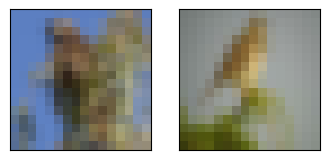

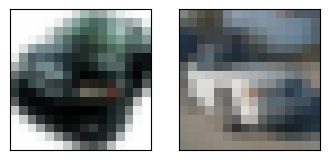

In [31]:
plot_images(get_fixed_samples(datasetP,2))
plot_images(get_fixed_samples(datasetQ,2))

In [32]:
def weak_sq_cost(X, T_XZ, gamma):
    """
    Input
    --------
    X : tensor, shape (bs, dim) or (bs, n_ch, w, h)
    T_XZ : tensor, shape (bs, z_size, dim) or (bs, z_size, n_ch, w, h)
    gamma : float

    Output
    --------
    cost : tensor, shape ()
    """
    X = X.flatten(start_dim=1) # flatten all dimensions except batch
    T_XZ = T_XZ.flatten(start_dim=2) # flatten all dimensions except batch and z

    l2 = (X[:,None] - T_XZ).square().sum(dim=2).mean()
    var = T_XZ.var(dim=1).sum(dim=1).mean()
    return l2 - 0.5 * gamma * var

def weak_kernel_cost(X, T_XZ, gamma):
    X = X.flatten(start_dim=1)
    T_XZ = T_XZ.flatten(start_dim=2)
    z_size = T_XZ.size(1)

    l2_dist = (X[:,None] - T_XZ).norm(dim=2).mean()
    kvar = .5 * torch.cdist(T_XZ, T_XZ).mean() * z_size / (z_size -1)
    return l2_dist - 0.5 * gamma * kvar

In [33]:
class Modelf(nn.Module):
    def __init__(self):
        super(Modelf, self).__init__()
        self.network =  nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.AvgPool2d(2), #  128 x 8 x 8
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.AvgPool2d(2), #  256 x 4 x 4
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.AvgPool2d(2), #  512 x 2 x 2
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.AvgPool2d(2), #  512 x 1 x 1
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
            nn.Flatten(1),
        )

    def forward(self, x):
        return self.network(x)

class ModelT(nn.Module):
    def __init__(self):
        super(ModelT, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3+1, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Conv2d(128, 3, kernel_size=5, padding=2),
        )

    def forward(self, xz):
        return self.network(xz)

In [34]:
def hide_z(batch):
    "Converts batch B x Z x C x H x W -> BZ x C x H x W"
    return batch.reshape(batch.shape[0]*batch.shape[1], *batch.shape[2:])

def restore_z(batch, batch_size):
    "Converts batch BZ x C x H x W -> B x Z x C x H x W"
    return batch.reshape(batch_size, -1, *batch.shape[1:])

def fetch_batch(data_loader_iter, data_loader):
    try:
        # fetching the next batch
        batch, _ = next(data_loader_iter)
    except StopIteration:
        # the DataLoader is exhausted, reinitialize the iterator
        data_loader_iter = iter(data_loader)
        batch, _ = next(data_loader_iter)
    return batch, data_loader_iter


def train(model_T, model_f, optimizer_T, optimizer_f, max_steps, train_loader_P,train_loader_Q, T_iters, batch_size,z_size,cost_function,XZ_fixed, X_fixed, Y_fixed,gamma=1.0):
    """
    Train the model_T and model_f using the given optimizers and cost function.

    Args:
    model_T: torch.nn.Module, the T model to train
    model_f: torch.nn.Module, the f model to train
    optimizer_T: torch.optim.Optimizer, the optimizer for model_T
    optimizer_f: torch.optim.Optimizer, the optimizer for model_f
    max_steps: int, the number of training steps to do
    train_loader_P: dataloader, dataloader to sample from distribution P
    train_loader_Q: dataoloader, dataloader to sample from distribution Q
    T_iters: int, the number of iterations to train model_T per step
    batch_size: int, the number of samples to draw from the dataset per step
    z_size: int, the number of noise vectors to sample per sample from the dataset
    cost_function: function, the cost function to use for training
    XZ_fixed: torch.Tensor, the fixed samples to use for plotting
    X_fixed: torch.Tensor, the fixed samples to use for plotting
    Y_fixed: torch.Tensor, the fixed samples to use for plotting
    """

    iter_loader_P = iter(train_loader_P)
    iter_loader_Q = iter(train_loader_Q)

    for step in tqdm(range(max_steps)):

        # Optimize T
        model_T.train()
        model_f.eval()

        for _ in range(T_iters):

            X, iter_loader_P = fetch_batch(iter_loader_P, train_loader_P)
            X = X.to(DEVICE)

            Z = torch.randn(X.shape[0], z_size, 1,X.shape[2],X.shape[3]).to(DEVICE)

            XZ = torch.cat([X[:,None].repeat(1,z_size,1,1,1), Z], dim=2) # (bs, z_size, 3+1, 32, 32)
            T_XZ = restore_z(model_T(hide_z(XZ)), X.shape[0]) # (bs, z_size, 3, 32, 32)

            T_loss = cost_function(X, T_XZ, gamma) - model_f(hide_z(T_XZ)).mean()

            optimizer_T.zero_grad()
            T_loss.backward()
            optimizer_T.step()

        # Optimize f
        model_T.eval()
        model_f.train()

        X, iter_loader_P = fetch_batch(iter_loader_P, train_loader_P)
        X = X.to(DEVICE)# (bs, 3, 32, 32)

        Y, iter_loader_Q = fetch_batch(iter_loader_Q, train_loader_Q)
        Y = Y.to(DEVICE) # (bs, 3, 32, 32)

        Z = torch.randn(X.shape[0], z_size, 1,X.shape[2],X.shape[3]).to(DEVICE)
        XZ = torch.cat([X[:,None].repeat(1,z_size,1,1,1), Z], dim=2) # (bs, z_size, 3+1, 32, 32)

        T_XZ = restore_z(model_T(hide_z(XZ)), X.shape[0])
        f_loss = model_f(hide_z(T_XZ)).mean() - model_f(Y).mean()

        optimizer_f.zero_grad()
        f_loss.backward()
        optimizer_f.step()

        if step % 5 == 0:
            clear_output(wait=True)
            print("Step", step)
            print("T_loss", T_loss.item())
            print("f_loss", f_loss.item())

            plot_results(gamma, XZ_fixed, X_fixed, Y_fixed, model_T,z_size)


def plot_results(gamma, XZ_test_fixed, X_test_fixed, Y_test_fixed, T,z_size):
    print('gamma={}'.format(gamma))

    nb_samples = X_test_fixed.shape[0]

    with torch.no_grad():
        T_XZ_test_fixed = T(
            XZ_test_fixed.to(DEVICE).flatten(start_dim=0, end_dim=1)
        ).permute(1,2,3,0).reshape(3,X_test_fixed.shape[2],X_test_fixed.shape[3],nb_samples,z_size).permute(3,4,0,1,2).to('cpu')
    print('Mnist-2 images X, mapped images T(X, Z), unpaired Mnist-3 images Y')
    plot_images(X_test_fixed)
    plot_many_images(T_XZ_test_fixed)
    plot_images(Y_test_fixed)
    plt.show()

In [35]:
torch.manual_seed(0)

z_size = 4

X_test_fixed = get_fixed_samples(datasetP_test, 10)
Y_test_fixed = get_fixed_samples(datasetQ_test, 10)
Z_test_fixed = torch.randn(10, z_size, 1, X_test_fixed.shape[2], X_test_fixed.shape[3])
with torch.no_grad():
    XZ_test_fixed = torch.cat([X_test_fixed[:,None].repeat(1,z_size,1,1,1), Z_test_fixed], dim=2)

Step 2665
T_loss 3.3268985748291016
f_loss -0.7144870758056641
gamma=0.5
Mnist-2 images X, mapped images T(X, Z), unpaired Mnist-3 images Y


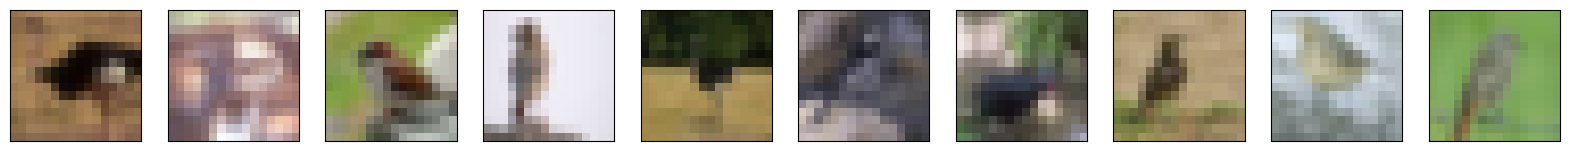

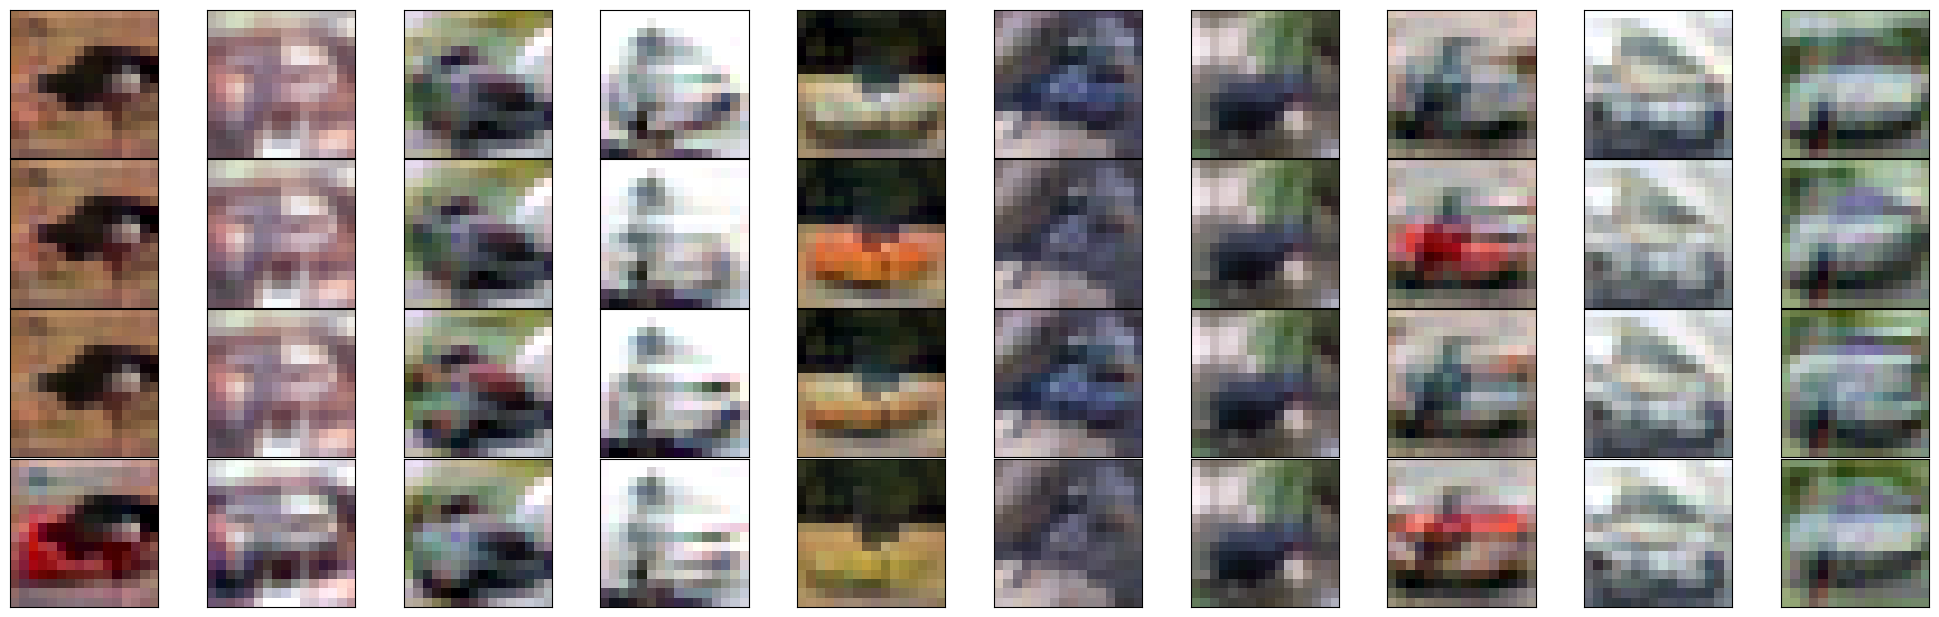

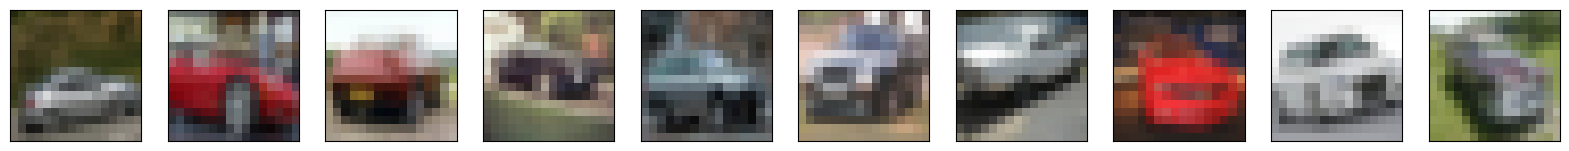

In [ ]:
print("WEAK KERNEL COST")
torch.manual_seed(1)

model_T = ModelT().to(DEVICE)
model_f = Modelf().to(DEVICE)

optim_T = torch.optim.Adam(model_T.parameters(), lr=1e-4, weight_decay=1e-10)
optim_f = torch.optim.Adam(model_f.parameters(), lr=1e-4, weight_decay=1e-10)

train(model_T, model_f, optim_T, optim_f,max_steps=10000, train_loader_P=train_loader_P,train_loader_Q=train_loader_Q, T_iters=10, batch_size=64, z_size=z_size, cost_function=weak_kernel_cost, XZ_fixed=XZ_test_fixed, X_fixed=X_test_fixed, Y_fixed=Y_test_fixed,gamma=0.5)